In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import shap
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
df = df.dropna()

In [7]:
#convertir datos categorico a numerico
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

In [8]:
#convertir datos de numerico a categorico
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')

In [9]:
df['ChurnTarget'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)
df['ChurnTarget'].value_counts(normalize=True)

ChurnTarget
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ChurnTarget
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [11]:
df_proccessed = df.drop(["customerID", "Churn"], axis=1)
df_proccessed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnTarget
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [12]:
df_proccessed = pd.get_dummies(df_proccessed, drop_first=True)

In [13]:
df_proccessed.head()

,tenure,MonthlyCharges,TotalCharges,ChurnTarget,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [14]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [15]:
X = df_proccessed.drop("ChurnTarget", axis=1)
y = df_proccessed["ChurnTarget"]

In [16]:
print(f"Porcentaje de churn positivo: {y.mean():.2%}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Porcentaje de churn positivo: 26.54%


In [17]:
print('🔄 Randomized Search iniciado...')
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [20, 30, 40, 50],
    'min_samples_split': [6, 8, 10, 12],
    'min_samples_leaf': [7, 8, 9, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'bootstrap': [True, False]
}

rscv = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist,
                          n_iter=20, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1)
rscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Random Search):", rscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, rscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rscv.predict(X_test)))

🔄 Randomized Search iniciado...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🏁 Mejor configuración (Random Search): {'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': False}
🔍 AUC test: 0.8414293786868074
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1552
           1       0.54      0.78      0.64       561

    accuracy                           0.77      2113
   macro avg       0.73      0.77      0.74      2113
weighted avg       0.81      0.77      0.78      2113



In [18]:
print('🔄 Grid Search iniciado...')
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [16, 17],
    'min_samples_split': [6, 8],
    'min_samples_leaf': [8, 9, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'bootstrap': [True, False]
}

gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid,
                    scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Grid Search):", gscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, gscv.predict(X_test)))

🔄 Grid Search iniciado...
Fitting 3 folds for each of 192 candidates, totalling 576 fits
🏁 Mejor configuración (Grid Search): {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 400}
🔍 AUC test: 0.8435019157616186
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1552
           1       0.54      0.78      0.64       561

    accuracy                           0.77      2113
   macro avg       0.73      0.77      0.74      2113
weighted avg       0.81      0.77      0.78      2113



In [19]:
print('🔄 Bayesian Optimization iniciado...')

opt_space = {
    'n_estimators': Integer(1, 400),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(6, 12),
    'min_samples_leaf': Integer(6, 12),
    'max_features': Categorical(['sqrt', 'log2']),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'bootstrap': Categorical([True, False])
}

bsearch = BayesSearchCV(RandomForestClassifier(random_state=42),
                        search_spaces=opt_space,
                        n_iter=20,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs=-1,
                        verbose=1,
                        random_state=42)
bsearch.fit(X_train, y_train)

🔄 Bayesian Optimization iniciado...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for 

BayesSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
              n_iter=20, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'class_weight': Categorical(categories=('balanced', 'balanced_subsample'), prior=None),
                             'max_depth': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=6, high=12, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=6, high=12, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=400, prior='uniform', transform='normalize')},
              verbose=1)

In [20]:
print("🏁 Mejor configuración (Bayesian Search):", bsearch.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, bsearch.predict_proba(X_test)[:,1]))
print(classification_report(y_test, bsearch.predict(X_test)))

🏁 Mejor configuración (Bayesian Search): OrderedDict([('bootstrap', False), ('class_weight', 'balanced_subsample'), ('max_depth', 16), ('max_features', 'log2'), ('min_samples_leaf', 11), ('min_samples_split', 6), ('n_estimators', 56)])
🔍 AUC test: 0.8421862653214988
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1552
           1       0.54      0.79      0.64       561

    accuracy                           0.76      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.76      0.78      2113



In [21]:
print('🔁 Aplicando SMOTE...')
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

rf_sm = RandomForestClassifier(**bsearch.best_params_, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)

print("✅ Resultados con SMOTE")
print("🔍 AUC test:", roc_auc_score(y_test, rf_sm.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rf_sm.predict(X_test)))

🔁 Aplicando SMOTE...
✅ Resultados con SMOTE
🔍 AUC test: 0.8351652516676773
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1552
           1       0.56      0.64      0.60       561

    accuracy                           0.77      2113
   macro avg       0.71      0.73      0.72      2113
weighted avg       0.78      0.77      0.78      2113



📊 Visualizaciones iniciadas...


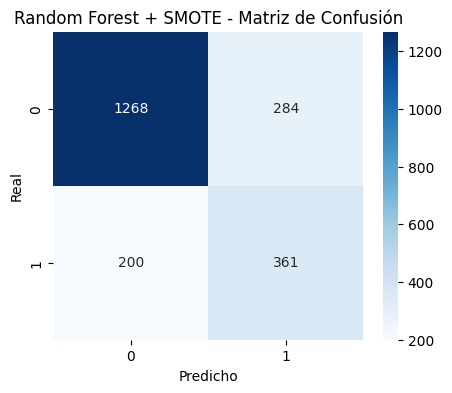

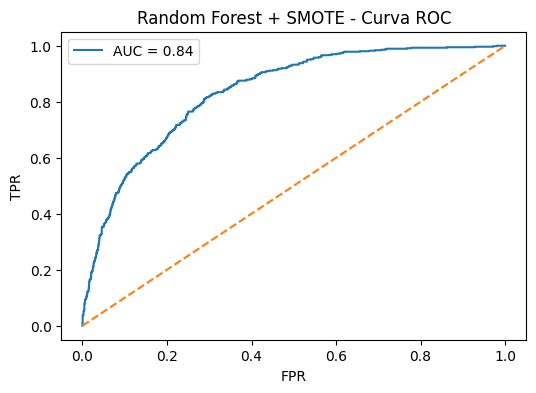

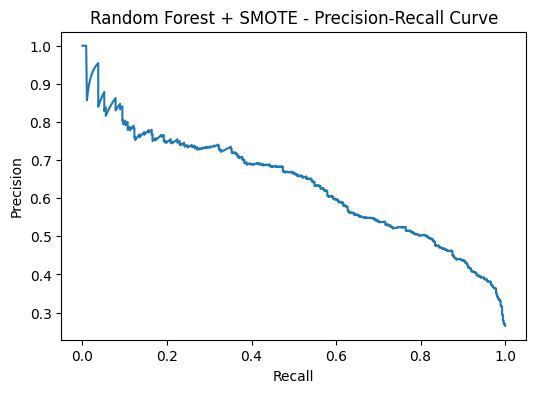

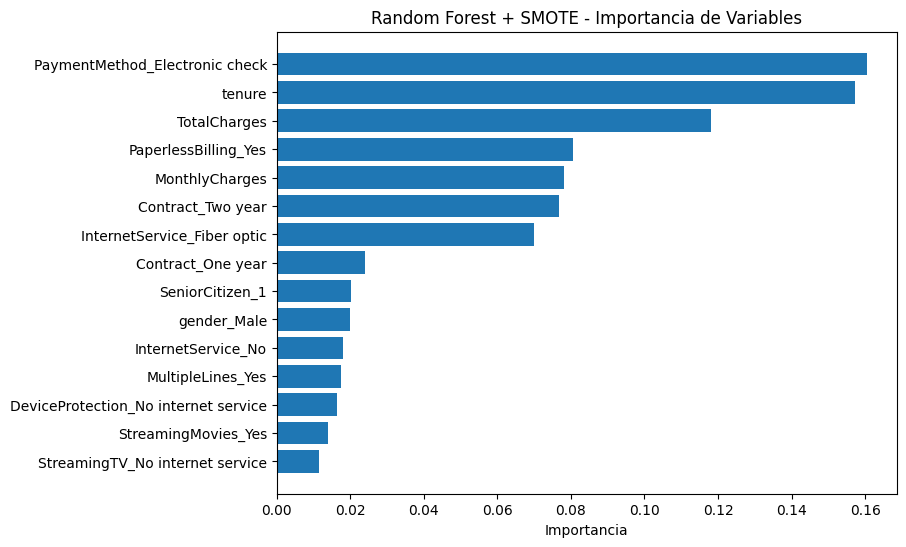

In [22]:
print('📊 Visualizaciones iniciadas...')
def plot_model_performance(model, X_test, y_test, model_name="Modelo"):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Matriz de Confusión")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"{model_name} - Curva ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

def plot_feature_importance(model, feature_names, top_n=15, model_name="Modelo"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importancia")
    plt.title(f"{model_name} - Importancia de Variables")
    plt.show()

plot_model_performance(rf_sm, X_test, y_test, model_name="Random Forest + SMOTE")
plot_feature_importance(rf_sm, X.columns, top_n=15, model_name="Random Forest + SMOTE")

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
 
# Prepare the preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
    ])
 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=300, max_depth = 16, max_features='log2',
    class_weight = 'balanced', min_samples_leaf = 2, min_samples_split = 3))
])
 
# Train the logistic regression model
pipeline.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

In [ ]:
def plot_feature_importance(model, feature_names, top_n=6, model_name="Random Forest"):
    """Plots feature importance for the given model.
 
    Args:
        model: The trained model (pipeline).
        feature_names: The original feature names before OneHotEncoding.
        top_n: The number of top features to display.
        model_name: The name of the model for the plot title.
    """
    # Access the trained model and get feature importances
    importances = model.named_steps['classifier'].feature_importances_
   
    # Get feature names after OneHotEncoding
    onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
   
    # Combine numerical and one-hot encoded feature names
    all_feature_names = np.concatenate([num_features, onehot_columns])
   
    # Sort feature importances and get indices of top features
    indices = np.argsort(importances)[-top_n:]
   
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
   
    # Use all_feature_names for y-axis labels
    plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])  
   
    plt.xlabel("Importancia")
    plt.title(f"{model_name} - Importancia de Variables")
    plt.show()

In [ ]:
plot_feature_importance(pipeline, X.columns, top_n=5, model_name="Random Forest")

## guardar el modelo final

In [ ]:
import joblib
# Save the model
joblib.dump(pipeline, '../models')